In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


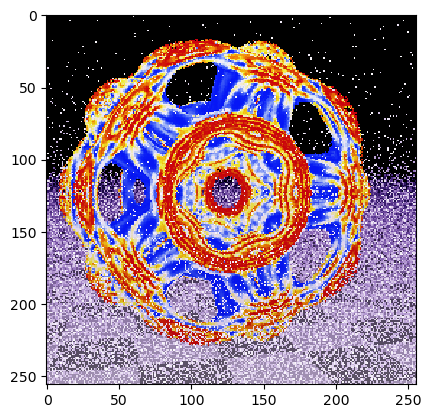

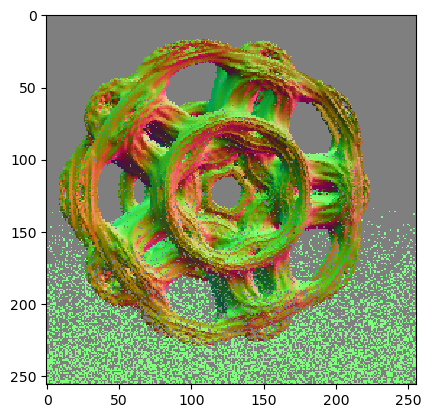

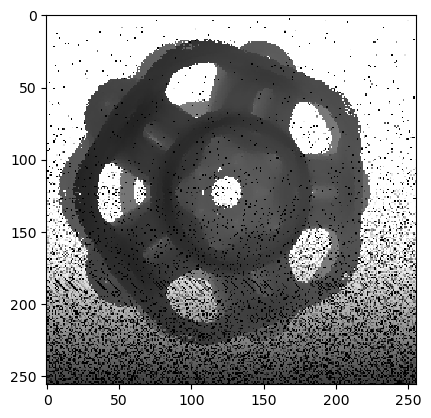

8 spp


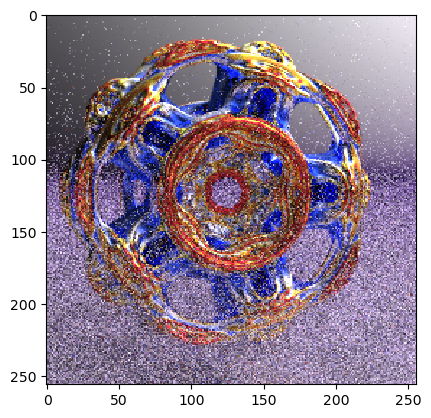

128 spp


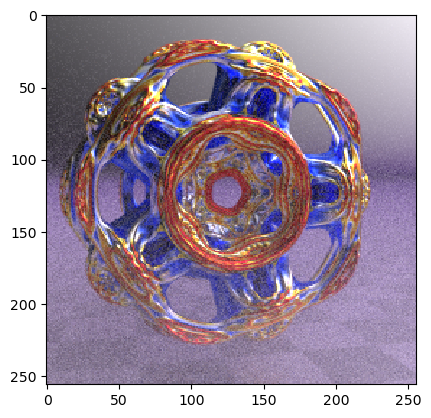

2048 spp


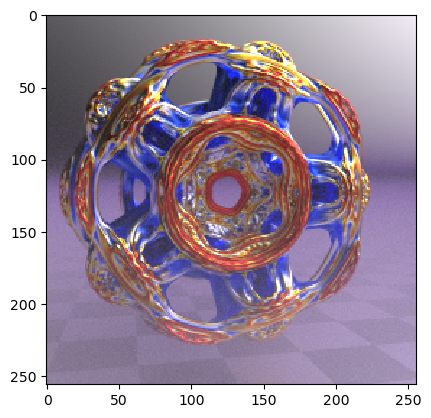

converged


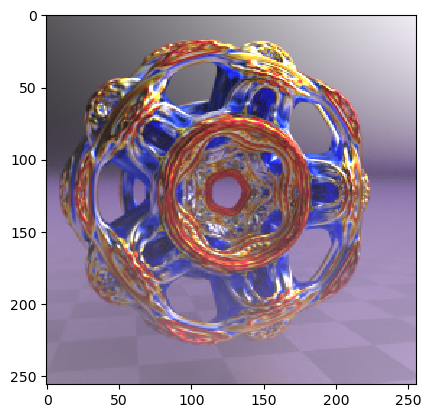

In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


_ = load_data_file("28c605de_15_256_256.bin", True)

torch.Size([32, 3, 64, 64])


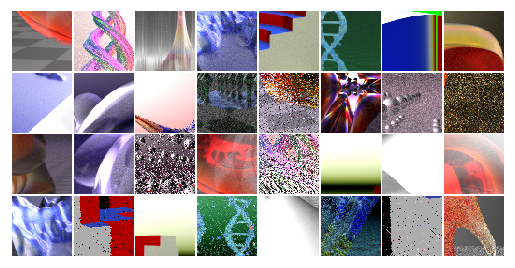

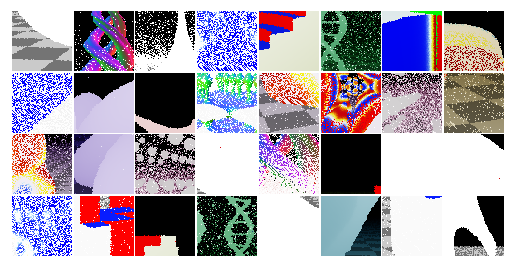

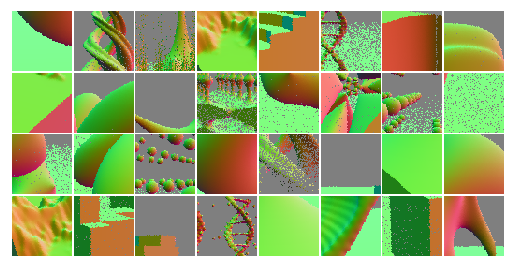

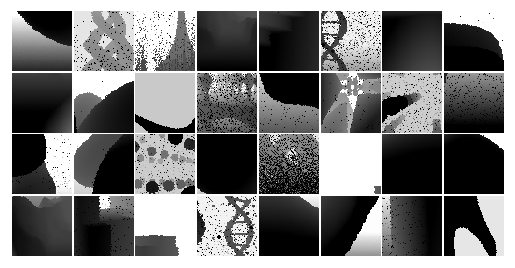

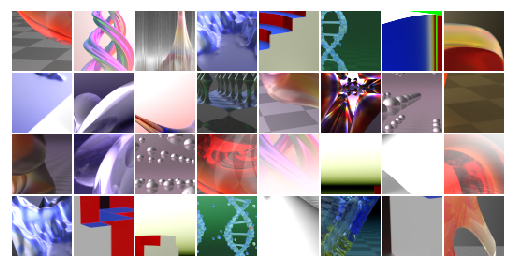

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 64
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s)
            y = np.random.randint(0, self.data[k]['h']-s)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=32,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n = 16
        self.convi = conv3(10, n)
        self.conv11 = conv3(n, n)
        self.conv12 = conv3(n, n)
        self.conv21 = conv3(n, n)
        self.conv22 = conv3(n, n)
        self.conv31 = conv3(n, n)
        self.conv32 = conv3(n, n)
        self.conv41 = conv3(n, n)
        self.conv42 = conv3(n, n)
        self.convo = conv3(n, 3)

    def forward(self, input):
        x = input
        # input
        ci = self.convi(x)
        xi = relu(ci)
        # residual 1
        c11 = self.conv11(xi)
        x = relu(c11)
        c12 = self.conv12(x)
        x1 = xi + c12
        # residual 2
        c21 = self.conv21(x1)
        x = relu(c21)
        c22 = self.conv22(x)
        x2 = x1 + c22
        # residual 3
        c31 = self.conv31(x2)
        x = relu(c31)
        c32 = self.conv32(x)
        x3 = x2 + c32
        # residual 4
        c41 = self.conv41(x3)
        x = relu(c41)
        c42 = self.conv42(x)
        x4 = x3 + c42
        # output
        co = self.convo(x4)
        return co

model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convo): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


256 0.0640488862991333
512 0.034004680812358856
768 0.031727977097034454
1024 0.02864031493663788
1280 0.029869725927710533
1536 0.03272530063986778
1792 0.021012529730796814
2048 0.02155487611889839
2304 0.022944506257772446
2560 0.025992345064878464
2816 0.02181650511920452
3072 0.016864581033587456
3328 0.017239797860383987
3584 0.022414684295654297
3840 0.018418870866298676
4096 0.02338053286075592


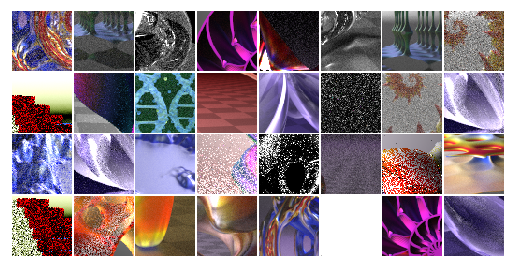

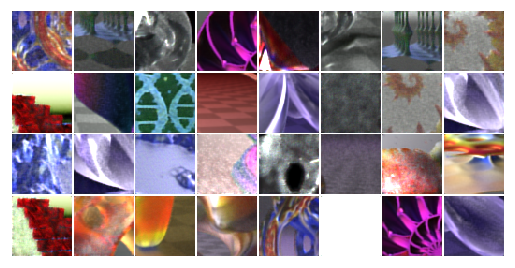

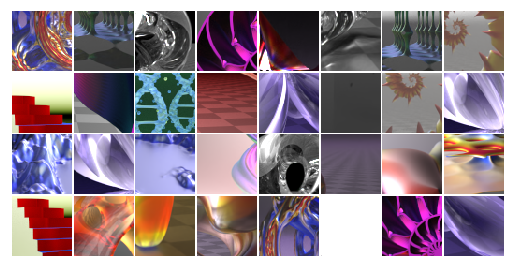

4352 0.021328937262296677
4608 0.014527211897075176
4864 0.017350949347019196
5120 0.01987013779580593
5376 0.015678666532039642
5632 0.018957145512104034
5888 0.021005701273679733
6144 0.015496876090765
6400 0.016622161492705345
6656 0.020777426660060883
6912 0.014947752468287945
7168 0.014310428872704506
7424 0.013924291357398033
7680 0.01676490344107151
7936 0.01438708882778883
8192 0.01217544823884964


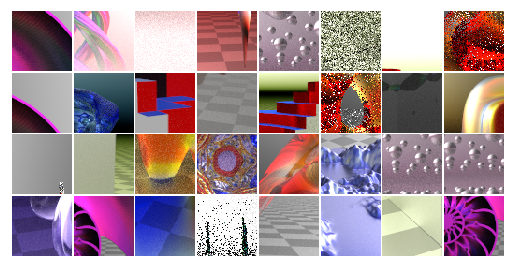

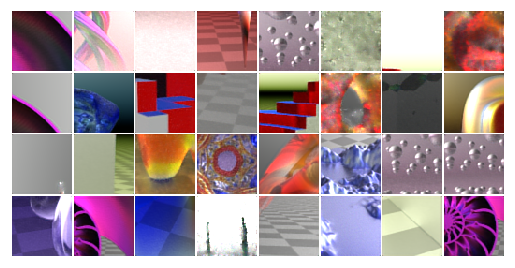

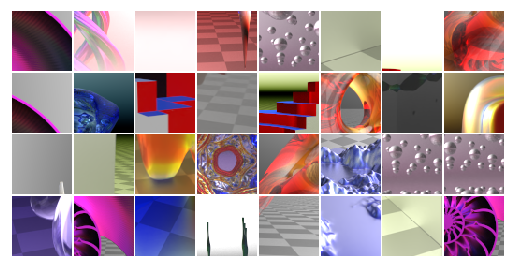

8448 0.015429886989295483
8704 0.020246285945177078
8960 0.01812255010008812
9216 0.012475627474486828
9472 0.016842622309923172
9728 0.015342666767537594
9984 0.01847955398261547
10240 0.01933687925338745
10496 0.013931713998317719
10752 0.015838928520679474
11008 0.014647919684648514
11264 0.011112140491604805
11520 0.012300300411880016
11776 0.011531149968504906
12032 0.018065093085169792
12288 0.012518125586211681


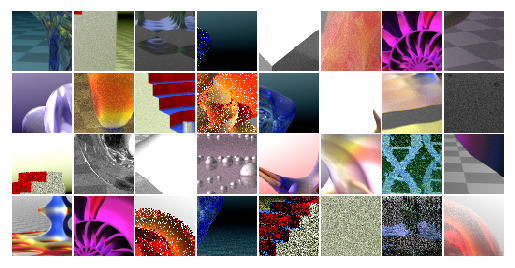

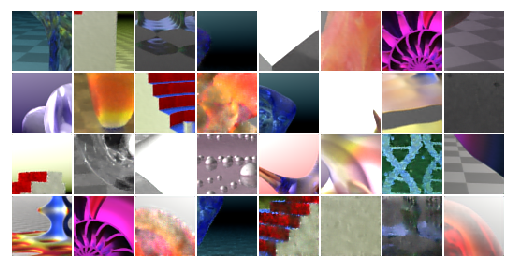

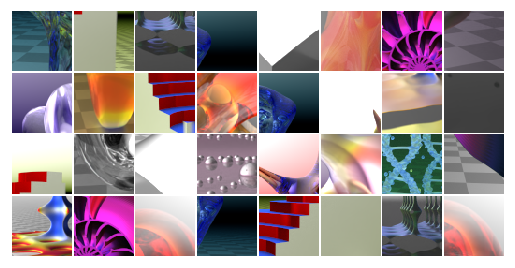

12544 0.010460685938596725
12800 0.015293325297534466
13056 0.011252878233790398
13312 0.015163118951022625
13568 0.01562669686973095
13824 0.014750044792890549
14080 0.0126179289072752
14336 0.01058784406632185
14592 0.01427337434142828
14848 0.017464471980929375
15104 0.015209443867206573
15360 0.0161447636783123
15616 0.01548752747476101
15872 0.016131475567817688
16128 0.015234796330332756
16384 0.013997937552630901


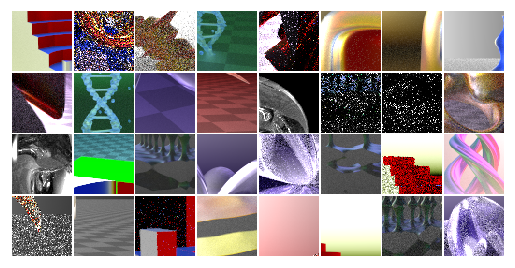

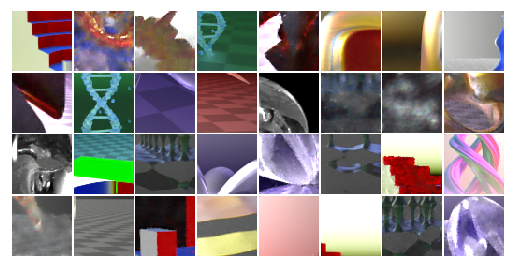

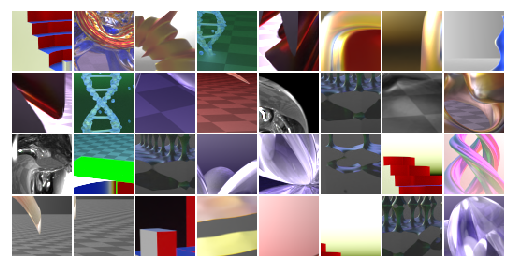

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

def lossfun(output, reference, input):
    return torch.mean(torch.abs(output-reference))

batch_count = 0
for epoch in range(1):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**19), batch_size=32, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((x, a), axis=1)
        output = model(m_in)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1.pth")